In [6]:
# normal stuff
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from astropy.io import ascii
from astropy.table import Table

%matplotlib inline

# set some global options
plt.rcParams['figure.figsize'] = (6,5)
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.borderpad'] = 0.1
plt.rcParams['legend.labelspacing'] = 0.1
plt.rcParams['legend.handletextpad'] = 0.1
plt.rcParams['font.family'] = 'stixgeneral'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.size'] = 16

# Version with self-gravity

In [7]:
def integrate_envelope_self_grav(rho_in,P_in,
                       R_in=0.5,R_out=10.0, 
                       M1=1.0,
                       Ggrav=6.67408e-8,
                       npoints=5000,
                       gamma=5./3.,
                       gamma_structure=5./3.,
                       p_min=1.e-2,
                       cs_corona=1.0,
                       include_self_grav=True):
    
    radii = np.linspace(R_in,R_out,npoints)
    rho = np.zeros_like(radii)
    P = np.zeros_like(radii)
    m = np.zeros_like(radii)
    
    dr = radii[1]-radii[0]
    
    rho[0] = rho_in
    P[0] = P_in
    m[0] = M1
    
    
    # DEFINE A DERIVATIVES FUNCTION # # #
    def derivsStar(r,vec):
        rho = vec[0]
        p   = vec[1]
        m   = vec[2]
    
        g = Ggrav * m * r**(-2)
    
        drhodr = - g*(rho**2 /(gamma_structure * p) )  
        dpdr   = - g*rho
        if(include_self_grav):
            dmdr   = 4*np.pi*r**2*rho
        else:
            dmdr = 0.0
    
        return np.array([drhodr,dpdr,dmdr])
    # # # # # # # # # # # # # # # # # # #
    
    # DEFINE A DERIVATIVES FUNCTION (CORONA) # # #
    def derivsCorona(r,vec):
        rho = vec[0]
        p   = vec[1]
        m   = vec[2]
    
        g = Ggrav * m * r**(-2)
    
        #cs = np.sqrt(gamma*p/rho)
        cs = cs_corona;
        drhodr = -g*rho *gamma* cs**-2 #-g *(rho**2 /(gamma * p) )   #-g*rho * cs**-2 #- g*(rho**2 /(gamma_structure * p) )  
        dpdr   = - g*rho
        dmdr   = 4*np.pi*r**2*rho
    
        return np.array([drhodr,dpdr,dmdr])
    # # # # # # # # # # # # # # # # # # #
    imax_star = 0
    rpvec0 = np.array([rho[0],P[0],m[0]]) 
    for i in np.arange(1,npoints,1):
        #print "Star"
        k1 = dr*derivsStar(radii[i-1],rpvec0)
        k2 = dr*derivsStar(radii[i-1]+dr/2.,rpvec0+k1/2.)
        k3 = dr*derivsStar(radii[i-1]+dr/2.,rpvec0+k2/2.)
        k4 = dr*derivsStar(radii[i-1]+dr,rpvec0+k3)
        rpvec = rpvec0 + (k1/6. + k2/3. + k3/3. + k4/6.) 

        rho[i] = rpvec[0]
        P[i]   = rpvec[1]
        m[i]   = rpvec[2]
                 
        rpvec0 = rpvec
            
        if (rpvec0[1]<=p_min):
            rho_transition = gamma*rpvec[1]/cs_corona**2 #rho_min_factor*rpvec[1] # change the density
            rpvec[0] = rho_transition
            imax_star = i
            break
    if(imax_star>0):        
        for i in np.arange(imax_star+1,npoints,1):
            #print "Corona"
            k1 = dr*derivsCorona(radii[i-1],rpvec0)
            k2 = dr*derivsCorona(radii[i-1]+dr/2.,rpvec0+k1/2.)
            k3 = dr*derivsCorona(radii[i-1]+dr/2.,rpvec0+k2/2.)
            k4 = dr*derivsCorona(radii[i-1]+dr,rpvec0+k3)
            rpvec = rpvec0 + (k1/6. + k2/3. + k3/3. + k4/6.) 

            rho[i] = rpvec[0]
            P[i] =   rpvec[1]
            m[i]   = rpvec[2]
                 
            rpvec0 = rpvec
            
    
    return radii,rho,P,m

    



# $\Gamma_{\rm s}=5/3$, $\gamma=5/3$, $m_{\rm core} = 0.1$ 

In [3]:
from scipy.optimize import root

def poly_root_envelope(rpvec,
                  Ggrav=1,M1=0.25,
                  R_in=0.1,R_out=1.5,
                  npoints=10000,
                  gamma_structure=5./3.,
                  gamma = 5./3.,
                  p_min=1.e-8,
                  cs_corona=1.0,
                  include_self_grav=True):
    
    rho_in = rpvec[0];
    p_in = rpvec[1];
    
    
    rad,rho,p,m = integrate_envelope_self_grav(rho_in,p_in,
                                         Ggrav=Ggrav,M1=M1,
                                         R_in=R_in,R_out=R_out,
                                         npoints=npoints,
                                         gamma_structure=gamma_structure,
                                         gamma = gamma,
                                         p_min=p_min,
                                         cs_corona=cs_corona,
                                          include_self_grav=include_self_grav)
    
    Radius = np.amax(rad[p>pa])
    Mass = np.interp(Radius,rad,m)

    return np.array([Mass-1,Radius-1])
    

Mass, Radius (solar units): 
1.0053176125121048 1.0035964035964038


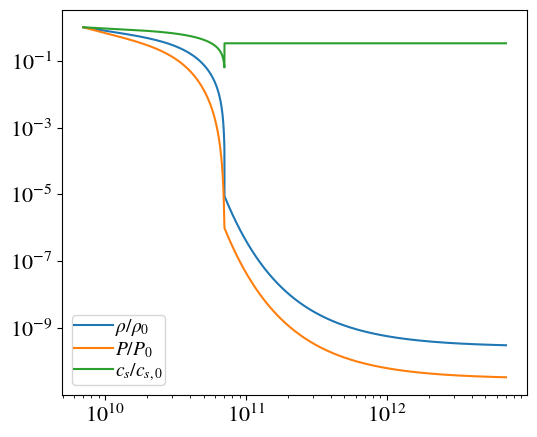

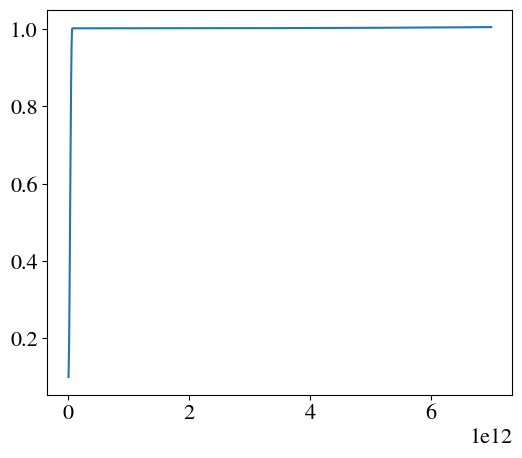

2e+32
13.498542274052475
2.2459775093710956e+16


In [4]:
Ggrav = 6.674e-8
rsun = 7e10
msun = 2e33
corona_sound_speed = 0.4*np.sqrt(Ggrav*msun/rsun)

rho_in = 2.315 * msun/rsun**3
p_in = 2.02*Ggrav*msun**2/rsun**4
pa = 1.e-6*p_in
gamma = 5/3.
poly_gamma=5/3.
mcore = 0.1*msun
rad,rho,p,m = integrate_envelope_self_grav(rho_in,p_in,
                                         Ggrav=Ggrav,M1=mcore,
                                         R_in=0.1*rsun,R_out=100*rsun,
                                         npoints=1000000,
                                         gamma_structure=poly_gamma,
                                         gamma = gamma,
                                         p_min=pa,
                                         cs_corona=corona_sound_speed,
                                          include_self_grav=True)

Radius = np.amax(rad[p>pa])

print( "Mass, Radius (solar units): ")
print(  m[-1]/msun,Radius/rsun)

plt.plot(rad,rho/rho[0],label=r'$\rho/\rho_0$')
plt.plot(rad,p/p[0],label=r'$P/P_0$')
plt.plot(rad,np.sqrt(5./3. * p/rho)/np.sqrt(5./3. * p[0]/rho[0]),label=r'$c_s/c_{s,0}$')
plt.legend(loc=0)
plt.yscale('log')
plt.xscale('log')
plt.show()

plt.plot(rad,m/msun,label=r'$m$')
#plt.xlim(0,2)
plt.show()


print( np.interp(0.3,rad,m))
print( np.interp(0.3,rad,rho))
print( np.interp(0.3,rad,p))

In [99]:
skip = 100
print( "Re-sampling to len:",len(rad[::skip]))

ascii.write(Table([rad[::skip],rho[::skip],p[::skip],m[::skip]]),
            format='no_header',output='hse_profile_cgs_solar_mc01.dat',overwrite=True)

Re-sampling to len: 10000


# Save FGONG

In [26]:
import fortranformat as ff

def convert_and_save_fgong(rad,rho,p,m,
                           gamma=5/3,poly_gamma=5./3.,
                           Ggrav=1,
                           output_filename="mypolytrope.fgong"):
    """ 
    based on gyre's poly_to_fgong.fpp
    http://www.astro.up.pt/corot/ntools/docs/CoRoT_ESTA_Files.pdf
    assumes that gamma, Ggrav, rad(nk), rho(nk),  m(nk), p(nk) are all defined. 
    rad,rho,p,m are numpy arrays of the same length
    gamma = adiabatic gamma
    poly_gamma = structural gamma of the polytrope
    Ggrav = grav const
    """
        

    # Params 
    IVERS = 300
    ICONST = 15
    IVAR = 40

    # Variables 
    nk = len(rad)
    
    # Dimensionless structure vars
    # 1/ gamma dlnP/dlnr - dln\rho/dlnr
    #As = (1/gamma * np.gradient(np.log(p))/np.gradient(np.log(rad)) -
    #      np.gradient(np.log(rho))/np.gradient(np.log(rad)) )

    #As = - G m rho/ r P (1/gamma - 1/gamma_structure)
    As = - Ggrav*m*rho/(rad*p) * (1/gamma - 1/poly_gamma)

    # Physical structure vars
    M_r = m.copy()
    M_r[m==0] = 1.e-38

    # global 
    glob = np.zeros(ICONST)
    glob[0] = m[-1]
    glob[1] = rad[-1]

    # vars
    var = np.zeros((IVAR,nk))

    # weird indexing to correspond to fortran naming in PDF
    var[1 -1,:] = rad
    var[2 -1,:] = np.log(M_r/M_r[-1])
    var[4 -1,:] = p
    var[5 -1,:] = rho
    var[10 -1,:] = gamma
    var[15 -1,:] = As

    # reverse order
    var = var[:,nk::-1].copy()
    
    
    # WRITE THE OUTPUT FILE
    f = open(output_filename,'w')

    header_line = ff.FortranRecordWriter('(15A)')

    for i in range(4):
        #print>>f, header_line.write("comment")
        f.write(header_line.write("comment\n"))
        
    index_line = ff.FortranRecordWriter('4I10')
    #print>>f, index_line.write([nk,ICONST,IVAR,IVERS]) 
    f.write(index_line.write([nk,ICONST,IVAR,IVERS]))
    f.write("\n")

    line = ff.FortranRecordWriter('1P5E16.9')
    #print>>f,  line.write(glob) 
    f.write(line.write(glob))
    f.write("\n")

    for k in range(nk):
        #print>>f, line.write(var[:,k]) 
        f.write(line.write(var[:,k]))
        f.write("\n")
    
    f.close()
    
    print ("Saving ",output_filename, "of length", nk)
    
    return

In [25]:
convert_and_save_fgong(rad[sel],rho[sel],p[sel],m[sel],
                      Ggrav=Ggrav,gamma=gamma,poly_gamma=poly_gamma,
                      output_filename="hse_profile_mc01_g135_gad135_R1.dat.fgong")

Saving  hse_profile_mc01_g135_gad135_R1.dat.fgong of length 3011


# LARGER RADIUS

Mass, Radius (rescaled): 
1.0021094125206238 0.9948420948420947


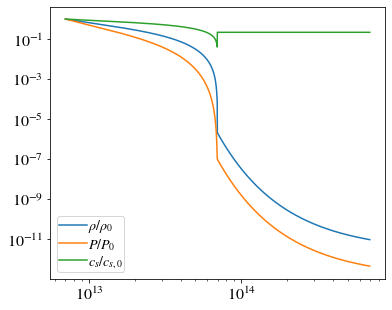

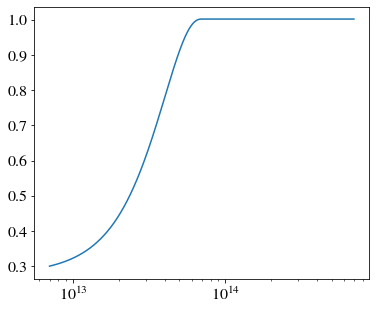

5.999999999999999e+32
2.099125364431487e-08
62309.19783423573


In [24]:
Ggrav = 6.674e-8
rsun = 7e10
msun = 2e33
rstar = 1000*rsun
mstar = 1*msun
corona_sound_speed = 0.35*np.sqrt(Ggrav*mstar/rstar)


rho_in = 3.6 * mstar/rstar**3
p_in = 5.604*Ggrav*mstar**2/rstar**4
pa = 1.e-7*p_in
gamma = 5/3.
poly_gamma=5/3.
mcore = 0.3*mstar
rad,rho,p,m = integrate_envelope_self_grav(rho_in,p_in,
                                         Ggrav=Ggrav,M1=mcore,
                                         R_in=0.1*rstar,R_out=10*rstar,
                                         npoints=1000000,
                                         gamma_structure=poly_gamma,
                                         gamma = gamma,
                                         p_min=pa,
                                         cs_corona=corona_sound_speed,
                                          include_self_grav=True)

Radius = np.amax(rad[p>pa])

print( "Mass, Radius (rescaled): ")
print(  m[-1]/mstar,Radius/rstar)

plt.plot(rad,rho/rho[0],label=r'$\rho/\rho_0$')
plt.plot(rad,p/p[0],label=r'$P/P_0$')
plt.plot(rad,np.sqrt(gamma * p/rho)/np.sqrt(gamma * p[0]/rho[0]),label=r'$c_s/c_{s,0}$')
plt.legend(loc=0)
plt.yscale('log')
plt.xscale('log')
plt.show()

plt.plot(rad,m/mstar,label=r'$m$')
#plt.xlim(0,2)

plt.xscale('log')
plt.show()


print( np.interp(0.3,rad,m))
print( np.interp(0.3,rad,rho))
print( np.interp(0.3,rad,p))

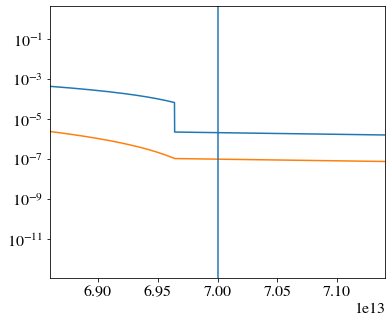

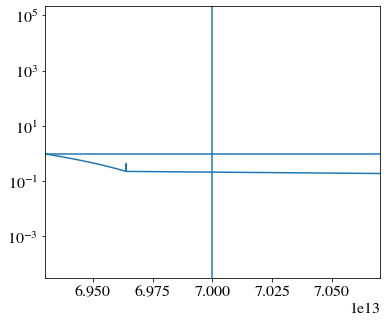

In [25]:
plt.semilogy(rad,rho/rho[0])
plt.semilogy(rad,p/p[0])
#plt.axhline(1)
plt.axvline(rstar)
plt.xlim(0.98*rstar,1.02*rstar)
plt.show()

Hp = -p/(np.gradient(p)/np.gradient(rad))
plt.semilogy(rad,rho*Hp)
plt.axhline(1)
plt.axvline(rstar)
plt.xlim(0.99*rstar,1.01*rstar)
plt.show()


In [26]:
rho

array([2.09912536e-08, 2.09888509e-08, 2.09864487e-08, ...,
       1.93975707e-19, 1.93975445e-19, 1.93975183e-19])

In [27]:
p

array([6.23091978e+04, 6.22973115e+04, 6.22854287e+04, ...,
       2.71864712e-08, 2.71864345e-08, 2.71863978e-08])

In [28]:
rad

array([7.00000000e+12, 7.00069300e+12, 7.00138600e+12, ...,
       6.99998614e+14, 6.99999307e+14, 7.00000000e+14])

In [30]:
skip = 100
print( "Re-sampling to len:",len(rad[::skip]))

ascii.write(Table([rad[::skip],rho[::skip],p[::skip],m[::skip]]),
            format='no_header',output='hse_profile_cgs_1000rsun_mc03_pa1e7_cs035.dat',overwrite=True)

Re-sampling to len: 10000


In [103]:
np.sqrt(rstar**3/(6.67e-8*mstar)) / 1.e7

5.070714341001274

In [35]:
vstar = np.sqrt(6.67e-8*mstar/rstar)
1.e-5*msun/3.15e7 / (4*np.pi*rstar**2 * vstar)

7.469380835552923e-15

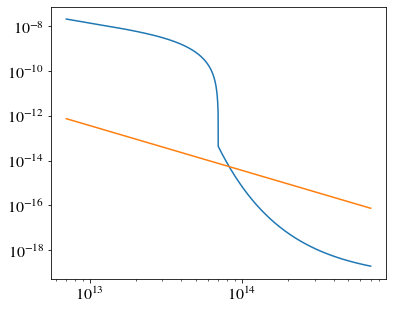

In [38]:
plt.plot(rad,rho)
plt.loglog(rad,1.e-5*msun/3.15e7 / (4*np.pi*rad**2 * vstar))

# MACHO object approximation (polytrope) 

Mass, Radius (rescaled): 
(1.0023846638430414, 1.0080919080919082)


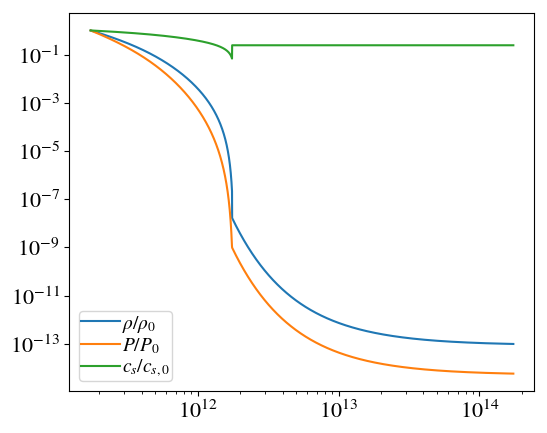

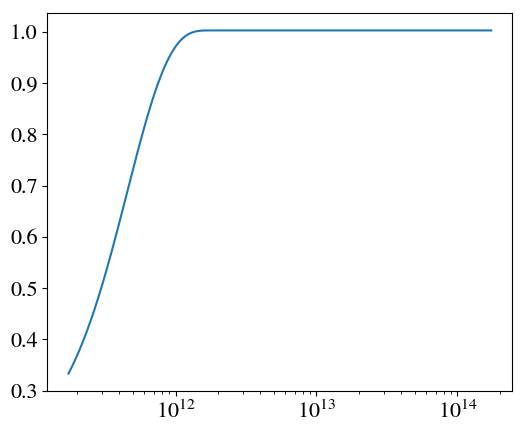

2.3e+34
0.240208710298
8.83017942684e+14


In [95]:
Ggrav = 6.674e-8
rsun = 6.955e10
msun = 2e33
rstar = 25.0*rsun
mstar = 34.5*msun
corona_sound_speed = 0.35*np.sqrt(Ggrav*mstar/rstar)


rho_in = 18.3 * mstar/rstar**3
p_in = 25.4*Ggrav*mstar**2/rstar**4
pa = 1.e-9*p_in
gamma = 1.5
poly_gamma=1.35
mcore = mstar/3.
rad,rho,p,m = integrate_envelope_self_grav(rho_in,p_in,
                                         Ggrav=Ggrav,M1=mcore,
                                         R_in=0.1*rstar,R_out=100*rstar,
                                         npoints=1000000,
                                         gamma_structure=poly_gamma,
                                         gamma = gamma,
                                         p_min=pa,
                                         cs_corona=corona_sound_speed,
                                          include_self_grav=True)

Radius = np.amax(rad[p>pa])

print( "Mass, Radius (rescaled): ")
print(  m[-1]/mstar,Radius/rstar)

plt.plot(rad,rho/rho[0],label=r'$\rho/\rho_0$')
plt.plot(rad,p/p[0],label=r'$P/P_0$')
plt.plot(rad,np.sqrt(gamma * p/rho)/np.sqrt(gamma * p[0]/rho[0]),label=r'$c_s/c_{s,0}$')
plt.legend(loc=0)
plt.yscale('log')
plt.xscale('log')
plt.show()

plt.plot(rad,m/mstar,label=r'$m$')
#plt.xlim(0,2)

plt.xscale('log')
plt.show()


print( np.interp(0.3,rad,m))
print( np.interp(0.3,rad,rho))
print( np.interp(0.3,rad,p))

In [96]:
skip = 100
print( "Re-sampling to len:",len(rad[::skip]))

ascii.write(Table([rad[::skip],rho[::skip],p[::skip],m[::skip]]),
            format='no_header',output='hse_profile_cgs_34.5msun_25rsun_mc033_pa1e9_cs035.dat',overwrite=True)

('Re-sampling to len:', 10000)


In [97]:
rstar/3 /1.e11

5.795833333333333

In [98]:
100*rstar / 1.e14

1.73875

In [99]:
rstar/1.e12

1.73875

# MACHO object v2: based on MESA

In [5]:
import pygyre as pg
#s = pg.read_output("/Users/morganmacleod/DATA/mesaruns/34.5M/gyre/summary_nad.txt")
#d2 = pg.read_output("/Users/morganmacleod/DATA/mesaruns/34.5M/gyre/detail_00002_002_+00_+00000_+00000.txt")



#plt.plot(d2['x']*s['R_star'][0],d2['rho'])
#plt.semilogy()
#plt.show()

#plt.plot(d2['x']*s['R_star'][0],d2['P'])
#plt.semilogy()
#plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/morganmacleod/DATA/mesaruns/34.5M/gyre/summary_nad.txt'

In [28]:
s['R_star'][0]/rsun

23.171289253360804

In [27]:
d2['M_r'][-1]/msun

34.31369999998284

In [4]:
Ggrav = 6.674e-8
rsun = 6.955e10
msun = 1.989e33
rstar = 23.171289253360804*rsun 
mstar = 34.31369999998284*msun
rho_in = 0.97*(mstar/rstar**3) 
p_in =  0.5115*(Ggrav*mstar**2 / rstar**4 )  
pa = 1.e-8*p_in

pa#/(Ggrav*mstar**2 / rstar**4 )  

235747.54270548993

Mass, Radius (rescaled): 
0.9993936237520137 1.0015896015896013
npoly, Bonnor (1958) stability criterion = 3.2573289902280136 True


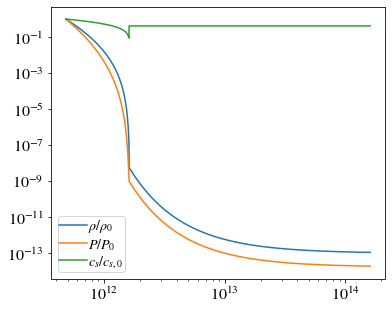

5.895049894556242e+34
0.01581728967892981
23574754270548.992


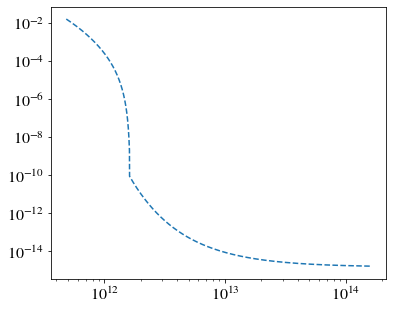

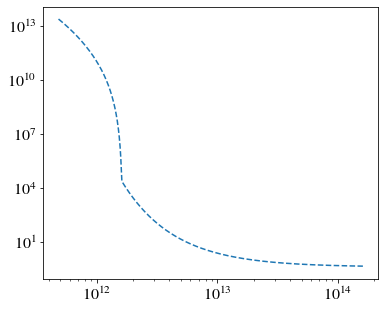

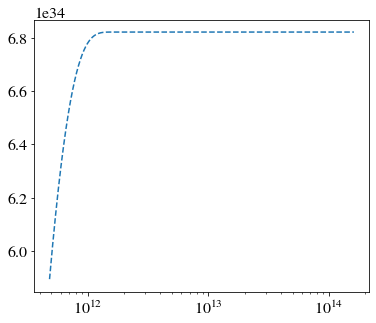

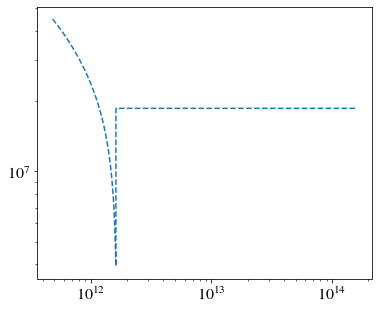

In [26]:
Ggrav = 6.674e-8
rsun = 6.955e10
msun = 1.989e33
rstar = 23.171289253360804*rsun #s['R_star'][0] #25.0*rsun
mstar = 34.31369999998284*msun #d2['M_r'][-1] #34.5*msun
corona_sound_speed = 0.35*np.sqrt(Ggrav*mstar/rstar)


rho_in = 0.97*(mstar/rstar**3) # d2['rho'][0] #18.3 * mstar/rstar**3
p_in =  0.5115*(Ggrav*mstar**2 / rstar**4 )  #d2['P'][0] #25.4*Ggrav*mstar**2/rstar**4
pa = 1.e-9*p_in
gamma = 1.35
poly_gamma= 1.307
mcore = 0.8637442159329471*mstar #d2['M_r'][0]
rad,rho,p,m = integrate_envelope_self_grav(rho_in,p_in,
                                         Ggrav=Ggrav,M1=mcore,
                                         R_in=0.3*rstar,R_out=100*rstar,
                                         npoints=1000000,
                                         gamma_structure=poly_gamma,
                                         gamma = gamma,
                                         p_min=pa,
                                         cs_corona=corona_sound_speed,
                                          include_self_grav=True)

Radius = np.amax(rad[p>pa])

print( "Mass, Radius (rescaled): ")
print(  m[-1]/mstar,Radius/rstar)

mstar = m[-1]
rstar = Radius


npoly = 1/(poly_gamma-1)
num = -(1 - (npoly-3)/(npoly+1)*(Ggrav*m[p>pa][-1]**2 / (8*np.pi*p[p>pa][-1]*rad[p>pa][-1]**4)))
denom = (1 - (npoly-3)/(npoly-1)*(m[p>pa][-1]/(3*rho[p>pa][-1]*(4/3*np.pi*rad[p>pa][-1]**3))))
print("npoly, Bonnor (1958) stability criterion =",npoly,num/denom<0)

plt.plot(rad,rho/rho[0],label=r'$\rho/\rho_0$')
plt.plot(rad,p/p[0],label=r'$P/P_0$')
plt.plot(rad,np.sqrt(gamma * p/rho)/np.sqrt(gamma * p[0]/rho[0]),label=r'$c_s/c_{s,0}$')
plt.legend(loc=0)
plt.yscale('log')
plt.xscale('log')
plt.show()



print( np.interp(0.3,rad,m))
print( np.interp(0.3,rad,rho))
print( np.interp(0.3,rad,p))


#plt.plot(d2['x']*s['R_star'][0],d2['rho'])
plt.plot(rad,rho,'--')
plt.loglog()
plt.show()


#plt.plot(d2['x']*s['R_star'][0],d2['P'])
plt.plot(rad,p,'--')
plt.loglog()
plt.show()

#plt.plot(d2['x']*s['R_star'][0],d2['M_r'])
plt.plot(rad,m,'--')
#plt.xlim(0,2)
plt.xscale('log')
plt.show()


#plt.plot(d2['x']*s['R_star'][0],np.sqrt(d2['Gamma_1']*d2['P']/d2['rho']) )
plt.plot(rad,np.sqrt(gamma*p/rho),'--')
#plt.xlim(0,2)
plt.loglog()
plt.show()



In [27]:
## Now we want to rescale this to arbitrary mass, radius... 

rad1 = rad/rstar 
rho1 = rho / (mstar/rstar**3)
p1   = p / (Ggrav*mstar**2 / rstar**4 )
m1   = m/mstar

In [28]:
skip = 100
print( "Re-sampling to len:",len(rad[::skip]))

ascii.write(Table([rad1[::skip],rho1[::skip],p1[::skip],m1[::skip]]),
            format='no_header',output='hse_profile_macho_unit_pa1e9_cs035.dat',overwrite=True)

Re-sampling to len: 10000


In [135]:
0.3 * rstar / 1.e11

4.846712904061431

In [131]:
mstar 

6.904690423202786e+34

In [138]:
np.sqrt(rstar**3/(Ggrav*mstar))/1.e4

3.024989374468549

In [30]:
p6 = ascii.read('hse_profile_macho_unit_pa1e6_cs035.dat',names=['r','rho','p','m'])
p8 = ascii.read('hse_profile_macho_unit_pa1e8_cs035.dat',names=['r','rho','p','m'])
p9 = ascii.read('hse_profile_macho_unit_pa1e9_cs035.dat',names=['r','rho','p','m'])
p10 = ascii.read('hse_profile_macho_unit_pa1e10_cs035.dat',names=['r','rho','p','m'])

(1e-11, 0.001)

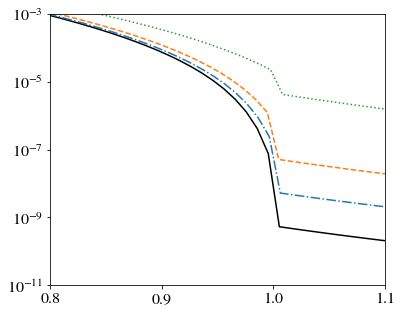

In [31]:
r6 = 1
r8 = 1

plt.plot(p10['r'],p10['rho'],'k-')
plt.plot(p9['r'],p9['rho'],'-.')
plt.plot(p8['r']*r8,p8['rho']/r8**3,ls="--")
plt.plot(p6['r']*r6,p6['rho']/r6**3,ls=':')

plt.semilogy()
plt.xlim(0.8,1.1)
plt.ylim(1.e-11,1.e-3)

(1e-11, 0.001)

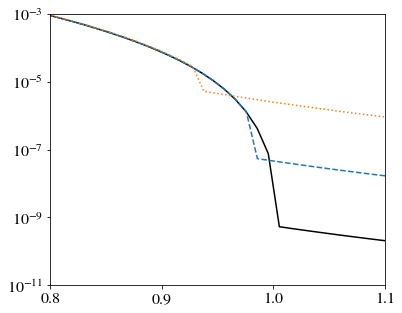

In [27]:
r6 = 0.93
r8 = 0.981

plt.plot(p10['r'],p10['rho'],'k-')
plt.plot(p8['r']*r8,p8['rho']/r8**3,ls="--")
plt.plot(p6['r']*r6,p6['rho']/r6**3,ls=':')

plt.semilogy()
plt.xlim(0.8,1.1)
plt.ylim(1.e-11,1.e-3)

In [29]:
(500/10)**0.5

7.0710678118654755

In [31]:
(10/500)**2 * 1e39

4e+35

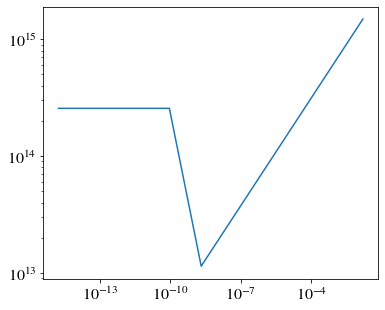

In [37]:
plt.loglog(rho,p/rho)


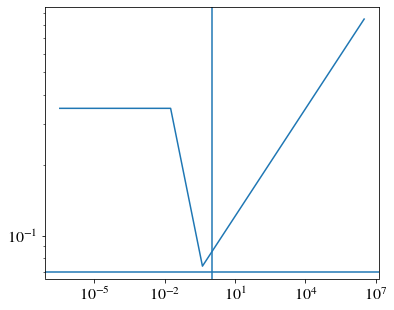

In [45]:
plt.loglog(rho*2e12*1.e-4,np.sqrt(1.35*p1/rho1))
plt.axhline(0.07)
plt.axvline(1)

# 2023 Version

Mass, Radius (rescaled): 
0.9898657348730997 0.9941794179417942
npoly, Bonnor (1958) stability criterion = 6.6666666666666705 True


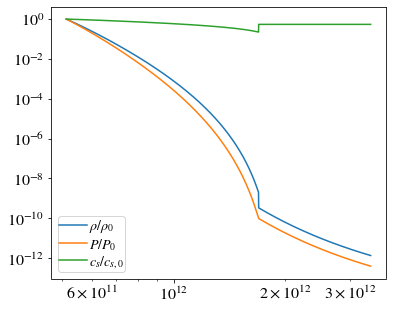

6.046810977243249e+34
0.027580966059887548
22931574056107.26


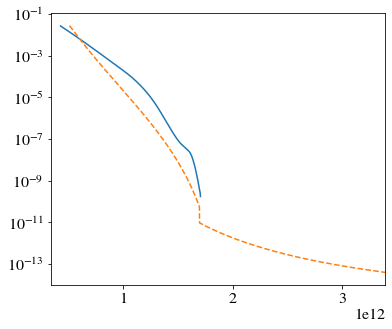

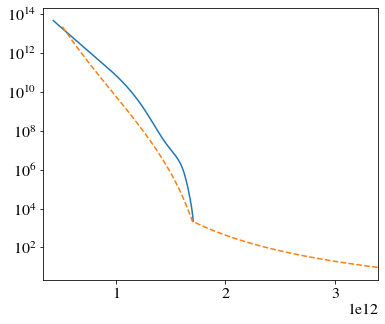

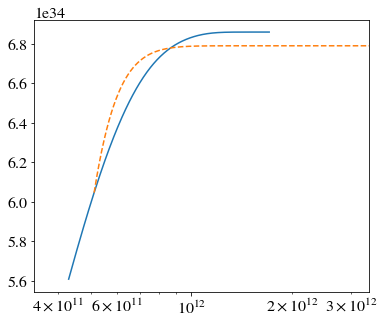

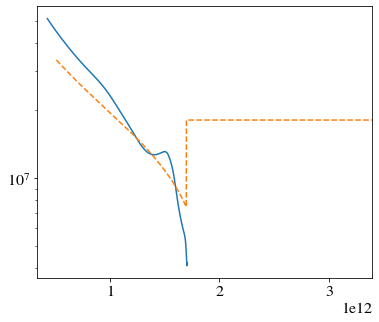

In [78]:
import pygyre as pg
mesa_model = pg.read_model("/Users/morganmacleod/DATA/mesaruns/machoHB/gyre/macho.gyre")
mesa_model = mesa_model[mesa_model['r']>0.25*mesa_model['r'][-1]].copy()

Ggrav = 6.674e-8
rsun = 6.955e10
msun = 1.989e33
rstar = mesa_model['r'][-1] 
mstar = mesa_model['M_r'][-1] 
corona_sound_speed = 0.35*np.sqrt(Ggrav*mstar/rstar)


rho_in = 2*(mstar/rstar**3) # d2['rho'][0] #18.3 * mstar/rstar**3
p_in =  0.62*(Ggrav*mstar**2 / rstar**4 )  #d2['P'][0] #25.4*Ggrav*mstar**2/rstar**4
pa = 1.e-10*p_in
gamma = 1.35
poly_gamma= 1.15
mcore = np.interp(0.3,mesa_model['r']/mesa_model['r'][-1],mesa_model['M_r'])
rad,rho,p,m = integrate_envelope_self_grav(rho_in,p_in,
                                         Ggrav=Ggrav,M1=mcore,
                                         R_in=0.3*rstar,R_out=2*rstar,
                                         npoints=10000,
                                         gamma_structure=poly_gamma,
                                         gamma = gamma,
                                         p_min=pa,
                                         cs_corona=corona_sound_speed,
                                          include_self_grav=True)

Radius = np.amax(rad[p>pa])

print( "Mass, Radius (rescaled): ")
print(  m[-1]/mstar,Radius/rstar)

mstar = m[-1]
rstar = Radius


npoly = 1/(poly_gamma-1)
num = -(1 - (npoly-3)/(npoly+1)*(Ggrav*m[p>pa][-1]**2 / (8*np.pi*p[p>pa][-1]*rad[p>pa][-1]**4)))
denom = (1 - (npoly-3)/(npoly-1)*(m[p>pa][-1]/(3*rho[p>pa][-1]*(4/3*np.pi*rad[p>pa][-1]**3))))
print("npoly, Bonnor (1958) stability criterion =",npoly,num/denom<0)

plt.plot(rad,rho/rho[0],label=r'$\rho/\rho_0$')
plt.plot(rad,p/p[0],label=r'$P/P_0$')
plt.plot(rad,np.sqrt(gamma * p/rho)/np.sqrt(gamma * p[0]/rho[0]),label=r'$c_s/c_{s,0}$')
plt.legend(loc=0)
plt.yscale('log')
plt.xscale('log')
plt.show()



print( np.interp(0.3,rad,m))
print( np.interp(0.3,rad,rho))
print( np.interp(0.3,rad,p))


plt.plot(mesa_model['r'],mesa_model['rho'])
plt.plot(rad,rho,'--')
plt.semilogy()
plt.xlim(0.2*rstar,2*rstar)
plt.show()


plt.plot(mesa_model['r'],mesa_model['P'])
plt.plot(rad,p,'--')
plt.semilogy()
plt.xlim(0.2*rstar,2*rstar)
plt.show()

plt.plot(mesa_model['r'],mesa_model['M_r'])
plt.plot(rad,m,'--')
#plt.xlim(0,2)
plt.xscale('log')
plt.xlim(0.2*rstar,2*rstar)
plt.show()


plt.plot(mesa_model['r'],np.sqrt(mesa_model['Gamma_1']*mesa_model['P']/mesa_model['rho']) )
plt.plot(rad,np.sqrt(gamma*p/rho),'--')
#plt.xlim(0,2)
plt.semilogy()
plt.xlim(0.2*rstar,2*rstar)
plt.show()

In [61]:
rad1 = rad/rstar 
rho1 = rho / (mstar/rstar**3)
p1   = p / (Ggrav*mstar**2 / rstar**4 )
m1   = m/mstar

In [62]:
skip = 100
print( "Re-sampling to len:",len(rad[::skip]))

ascii.write(Table([rad1[::skip],rho1[::skip],p1[::skip],m1[::skip]]),
            format='no_header',output='hse_profile_macho_unit_2023_pa1e8_cs035.dat',overwrite=True)

Re-sampling to len: 10000


(0.0, 2530449699792.8574)

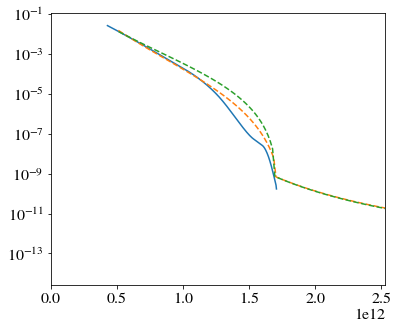

In [65]:
po = ascii.read('/Volumes/DATAVolume3/athenaruns/machoHB/hrd/hse_profile.dat',names=['r','rho','p','m'])
p8 = ascii.read('hse_profile_macho_unit_2023_pa1e8_cs035.dat',names=['r','rho','p','m'])

plt.plot(mesa_model['r'],mesa_model['rho'])
plt.plot(p8['r']*rstar,p8['rho']*(mstar/rstar**3),'--')
plt.plot(po['r']*rstar,po['rho']*(mstar/rstar**3),'--')
plt.semilogy()
plt.xlim(0,1.5*rstar)

6.046810977243249e+34

['r', 'rho', 'p', 'm']

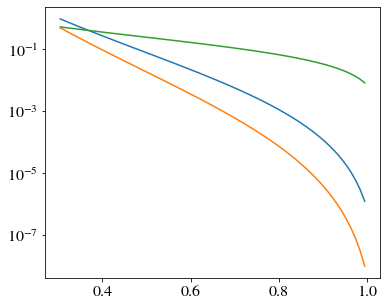

In [20]:
## Save fgong

p = ascii.read('/Volumes/DATAVolume3/athenaruns/machoHB/hrd/hse_profile.dat',names=['r','rho','p','m'])


sel=p['r']<=1.0
plt.plot(p[sel]['r'],p[sel]['rho'])
plt.plot(p[sel]['r'],p[sel]['p'])

plt.plot(p[sel]['r'],p[sel]['p']/p[sel]['rho'])
plt.semilogy()
#plt.xlim(0.95,)
p.keys()

In [28]:
convert_and_save_fgong(p[sel]['r'],p[sel]['rho'],p[sel]['p'],p[sel]['m'],gamma=1.35,poly_gamma=1.307,Ggrav=1,
                      output_filename='converted_polytrope_hrd.fgong')

Saving  converted_polytrope_hrd.fgong of length 69


 # M31 LRN progenitor

['zone', 'mass', 'logR', 'logT', 'logRho', 'logP', 'x_mass_fraction_H', 'y_mass_fraction_He', 'z_mass_fraction_metals', 'pp', 'cno', 'tri_alpha']
Mstar,Mcore,Rstar:
 7.952519458828395e+33 1.4653401825956107e+33 2482045207008.715
Mass, Radius (rescaled): 
1.0018849438161295 0.9891989198919892
npoly, Bonnor (1958) stability criterion = 1.6666666666666665 True


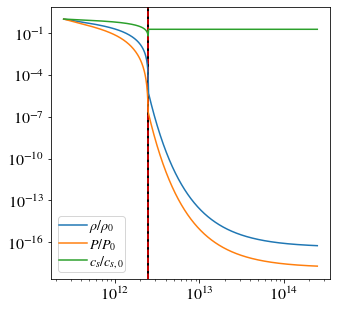

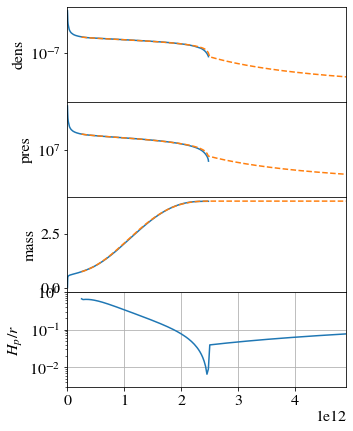

outside conditions
9.228552578178503e-07 1.104821610296235e-19
4.627865939245195e+26
min Hp/r =  0.006572222342889367 approx resolution factor ~ 0.0016430555857223418
min Hp/r (corona) = 0.03934516143343631


In [116]:
from astropy.table import Table

Ggrav = 6.674e-8
rsun = 6.955e10
msun = 1.989e33

mesa = Table.read("m31lrn_progenitor/LOGS/m31_lrn_prog.data",header_start=4,data_start=5,format='ascii')

print(mesa.keys())
mesa['r'] = (10**mesa['logR'])*rsun

rstar = mesa['r'][0] 
mstar = mesa['mass'][0]*msun 

corona_sound_speed = 0.25*np.sqrt(Ggrav*mstar/rstar)


rho_in = 3.75*(mstar/rstar**3) # d2['rho'][0] #18.3 * mstar/rstar**3
p_in =  4.3*(Ggrav*mstar**2 / rstar**4 )  #d2['P'][0] #25.4*Ggrav*mstar**2/rstar**4
pa = 1.e-6*p_in
gamma = 1.6
poly_gamma= 1.6
mcore = np.interp(0.1,np.flip(mesa['r']/rstar),np.flip(mesa['mass']) ) * msun
print("Mstar,Mcore,Rstar:\n",mstar,mcore,rstar)
rad,rho,p,m = integrate_envelope_self_grav(rho_in,p_in,
                                         Ggrav=Ggrav,M1=mcore,
                                         R_in=0.1*rstar,R_out=100*rstar,
                                         npoints=10000,
                                         gamma_structure=poly_gamma,
                                         gamma = gamma,
                                         p_min=pa,
                                         cs_corona=corona_sound_speed,
                                          include_self_grav=True)

Radius = np.amax(rad[p>pa])


print( "Mass, Radius (rescaled): ")
print(  m[-1]/mstar,Radius/rstar)

plt.figure(figsize=(5,5))
plt.axvline(rstar,color='k',lw=2)
plt.axvline(Radius,color='red',ls='--')


mstar = m[-1]
rstar = Radius


npoly = 1.0/(poly_gamma-1)
num = -(1 - (npoly-3)/(npoly+1)*(Ggrav*m[p>pa][-1]**2 / (8*np.pi*p[p>pa][-1]*rad[p>pa][-1]**4)))
denom = (1 - (npoly-3)/(npoly-1)*(m[p>pa][-1]/(3*rho[p>pa][-1]*(4/3*np.pi*rad[p>pa][-1]**3))))
print("npoly, Bonnor (1958) stability criterion =",npoly,num/denom<0)

plt.plot(rad,rho/rho[0],label=r'$\rho/\rho_0$')
plt.plot(rad,p/p[0],label=r'$P/P_0$')
plt.plot(rad,np.sqrt(gamma * p/rho)/np.sqrt(gamma * p[0]/rho[0]),label=r'$c_s/c_{s,0}$')
plt.legend(loc=0)
plt.yscale('log')
plt.xscale('log')
plt.show()






plt.figure(figsize=(5,7))
plt.subplot(411)
plt.plot(mesa['r'],10**mesa['logRho'])
plt.plot(rad,rho,'--')
plt.xticks(visible=False)
plt.ylabel('dens')
plt.semilogy()

plt.xlim(0,2*rstar)

plt.subplot(412)
plt.plot(mesa['r'],10**mesa['logP'])
plt.plot(rad,p,'--')
plt.semilogy()
plt.xticks(visible=False)
plt.ylabel('pres')

plt.xlim(0,2*rstar)

plt.subplot(413)
plt.plot(mesa['r'],mesa['mass'])
plt.plot(rad,m/msun,'--')
plt.xlim(0,2*rstar)
plt.ylabel('mass')
plt.xticks(visible=False)


plt.subplot(414)
plt.plot(rad,-np.gradient(rad)/np.gradient(np.log(p)) / rad)
plt.xlim(0,2*rstar)
plt.ylabel('$H_p/r$')
plt.semilogy()
plt.ylim(0.003,1)
plt.grid()

plt.subplots_adjust(hspace=0)

plt.show()

print("outside conditions")
print(p[-1], rho[-1] )
print(rho[-1] * 4/3*np.pi*(1e15)**3)


min_hpor = np.min(-np.gradient(rad)/np.gradient(np.log(p)) / rad)
min_hpor_corona = np.min((-np.gradient(rad)/np.gradient(np.log(p)) / rad)[np.sqrt(gamma * p/rho)==corona_sound_speed])
print("min Hp/r = ",min_hpor, "approx resolution factor ~",min_hpor/4   )
print("min Hp/r (corona) =",min_hpor_corona)

In [39]:
rad1 = rad/rstar 
rho1 = rho / (mstar/rstar**3)
p1   = p / (Ggrav*mstar**2 / rstar**4 )
m1   = m/mstar

In [40]:
skip = 100
print( "Re-sampling to len:",len(rad[::skip]))

ascii.write(Table([rad1[::skip],rho1[::skip],p1[::skip],m1[::skip]]),
            format='no_header',output='hse_profile_m31_pa1e-6_cs0.25.dat',overwrite=True)

Re-sampling to len: 10000


In [29]:
m1[-1] - np.interp(1,rad1,m1)

6.740654585102313e-05

In [5]:
(2*6.67e-8*5.25*2e33/(26.4*7e10))**0.5

27530974.291778076

In [4]:
10**1.421657

26.40322641965578

# M31 LRN progenitor -- E(B-V)=0.4

['zone', 'mass', 'logR', 'logT', 'logRho', 'logP', 'x_mass_fraction_H', 'y_mass_fraction_He', 'z_mass_fraction_metals', 'pp', 'cno', 'tri_alpha']
Mstar,Mcore,Rstar:
 1.042923411887852e+34 4.289915609851796e+33 1836343948398.422
Mass, Radius (rescaled): 
1.0008521343475998 1.0004995004995005
npoly, Bonnor (1958) stability criterion = 3.1249999999999996 -22.41816864840079 True


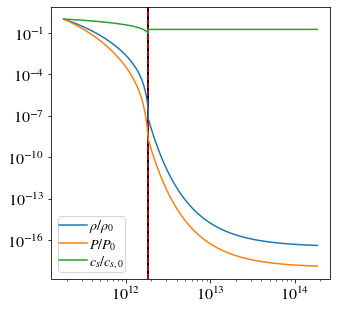

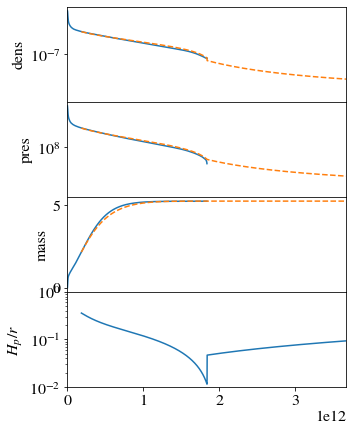

outside conditions
2.9972987147760375e-05 1.6869541737072298e-18
7.066297118748364e+27
min Hp/r =  0.011504036093673278 approx resolution factor ~ 0.0028760090234183195
min Hp/r (corona) = 0.04687268934605253


In [131]:
from astropy.table import Table

Ggrav = 6.674e-8
rsun = 6.955e10
msun = 1.989e33

mesa = Table.read("m31lrn_progenitorEBV04/LOGS/m31_lrn_prog.data",header_start=4,data_start=5,format='ascii')

print(mesa.keys())
mesa['r'] = (10**mesa['logR'])*rsun

rstar = mesa['r'][0] 
mstar = mesa['mass'][0]*msun 

corona_sound_speed = 0.25*np.sqrt(Ggrav*mstar/rstar)


rho_in = 23.9*(mstar/rstar**3) 
p_in =  35.32*(Ggrav*mstar**2 / rstar**4 )  
pa = 2.e-9*p_in
gamma = 1.33333
poly_gamma= 1.32
mcore = np.interp(0.1,np.flip(mesa['r']/rstar),np.flip(mesa['mass']) ) * msun
print("Mstar,Mcore,Rstar:\n",mstar,mcore,rstar)
rad,rho,p,m = integrate_envelope_self_grav(rho_in,p_in,
                                         Ggrav=Ggrav,M1=mcore,
                                         R_in=0.1*rstar,R_out=100*rstar,
                                         npoints=1000000,
                                         gamma_structure=poly_gamma,
                                         gamma = gamma,
                                         p_min=pa,
                                         cs_corona=corona_sound_speed,
                                          include_self_grav=True)

Radius = np.amax(rad[p>pa])


print( "Mass, Radius (rescaled): ")
print(  m[-1]/mstar,Radius/rstar)

plt.figure(figsize=(5,5))
plt.axvline(rstar,color='k',lw=2)
plt.axvline(Radius,color='red',ls='--')


mstar = m[-1]
#rstar = Radius


npoly = 1.0/(poly_gamma-1)
num = -(1 - (npoly-3)/(npoly+1)*(Ggrav*m[p>pa][-1]**2 / (8*np.pi*p[p>pa][-1]*rad[p>pa][-1]**4)))
denom = (1 - (npoly-3)/(npoly-1)*(m[p>pa][-1]/(3*rho[p>pa][-1]*(4/3*np.pi*rad[p>pa][-1]**3))))
print("npoly, Bonnor (1958) stability criterion =",npoly,num/denom,num/denom<0)

plt.plot(rad,rho/rho[0],label=r'$\rho/\rho_0$')
plt.plot(rad,p/p[0],label=r'$P/P_0$')
plt.plot(rad,np.sqrt(gamma * p/rho)/np.sqrt(gamma * p[0]/rho[0]),label=r'$c_s/c_{s,0}$')
plt.legend(loc=0)
plt.yscale('log')
plt.xscale('log')
plt.show()



plt.figure(figsize=(5,7))
plt.subplot(411)
plt.plot(mesa['r'],10**mesa['logRho'])
plt.plot(rad,rho,'--')
plt.xticks(visible=False)
plt.ylabel('dens')
plt.semilogy()

plt.xlim(0,2*rstar)

plt.subplot(412)
plt.plot(mesa['r'],10**mesa['logP'])
plt.plot(rad,p,'--')
plt.semilogy()
plt.xticks(visible=False)
plt.ylabel('pres')

plt.xlim(0,2*rstar)

plt.subplot(413)
plt.plot(mesa['r'],mesa['mass'])
plt.plot(rad,m/msun,'--')
plt.xlim(0,2*rstar)
plt.ylabel('mass')
plt.xticks(visible=False)


plt.subplot(414)
plt.plot(rad,-np.gradient(rad)/np.gradient(np.log(p)) / rad)
plt.xlim(0,2*rstar)
plt.ylabel('$H_p/r$')
plt.semilogy()
plt.ylim(0.01,1)

plt.subplots_adjust(hspace=0)

plt.show()

print("outside conditions")
print(p[-1], rho[-1] )
print(rho[-1] * 4/3*np.pi*(1e15)**3)

min_hpor = np.min(-np.gradient(rad)/np.gradient(np.log(p)) / rad)
min_hpor_corona = np.min((-np.gradient(rad)/np.gradient(np.log(p)) / rad)[np.sqrt(gamma * p/rho)==corona_sound_speed])
print("min Hp/r = ",min_hpor, "approx resolution factor ~",min_hpor/4   )
print("min Hp/r (corona) =",min_hpor_corona)

In [132]:
rad1 = rad/rstar 
rho1 = rho / (mstar/rstar**3)
p1   = p / (Ggrav*mstar**2 / rstar**4 )
m1   = m/mstar

In [133]:
skip = 100
print( "Re-sampling to len:",len(rad[::skip]))

ascii.write(Table([rad1[::skip],rho1[::skip],p1[::skip],m1[::skip]]),
            format='no_header',output='hse_profile_m31EBV_pa2e-9_cs0.25.dat',overwrite=True)

Re-sampling to len: 10000
